In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

### Laod Data

In [2]:
data = pd.read_csv("AirfoilSelfNoise.csv")

data.head()

,f,alpha,c,U_infinity,delta,SSPL
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


### Data Analysis

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   f           1503 non-null   int64  
 1   alpha       1503 non-null   float64
 2   c           1503 non-null   float64
 3   U_infinity  1503 non-null   float64
 4   delta       1503 non-null   float64
 5   SSPL        1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB


In [10]:
data.describe()

,f,alpha,c,U_infinity,delta,SSPL
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


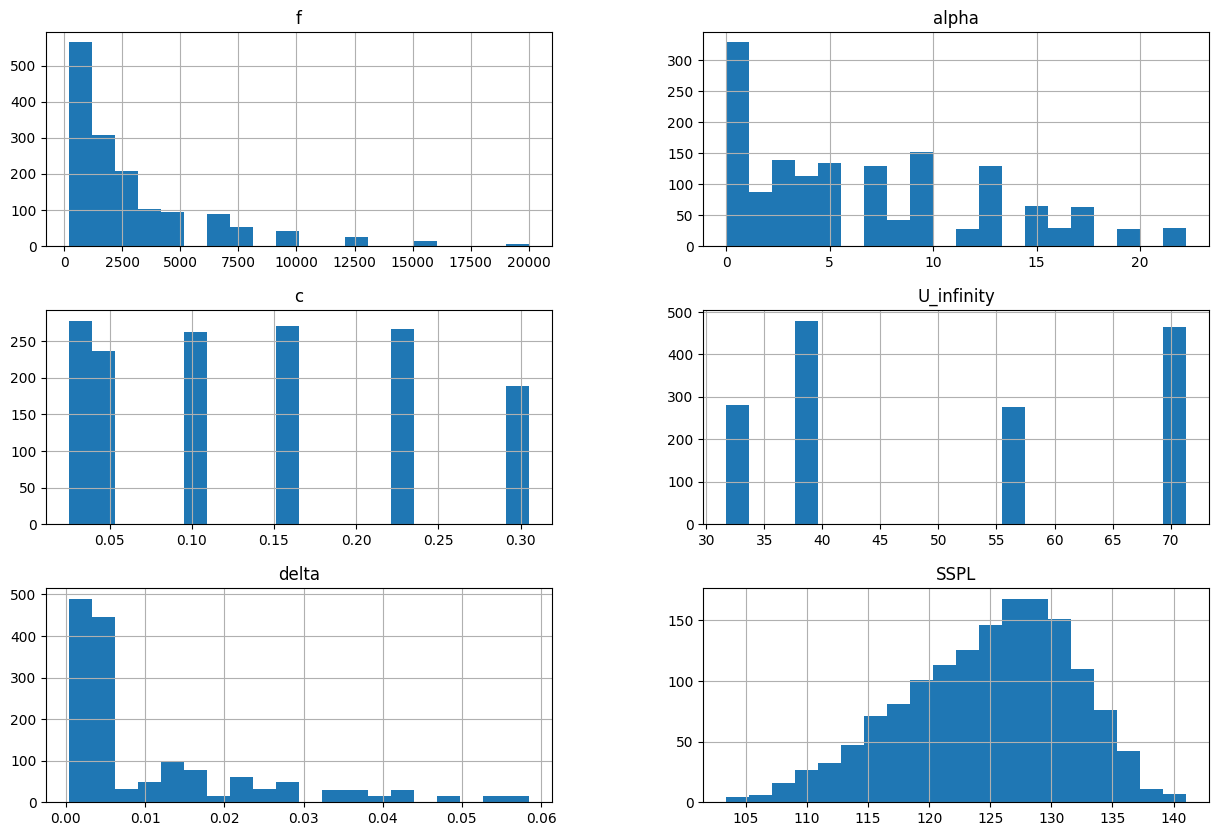

In [19]:
data.hist(figsize=(15,10), bins=20)
plt.show()

In [13]:
corr = data.corr(numeric_only=True)
corr.SSPL.sort_values(ascending=False)

SSPL          1.000000
U_infinity    0.125103
alpha        -0.156108
c            -0.236162
delta        -0.312670
f            -0.390711
Name: SSPL, dtype: float64

<Axes: xlabel='SSPL', ylabel='f'>

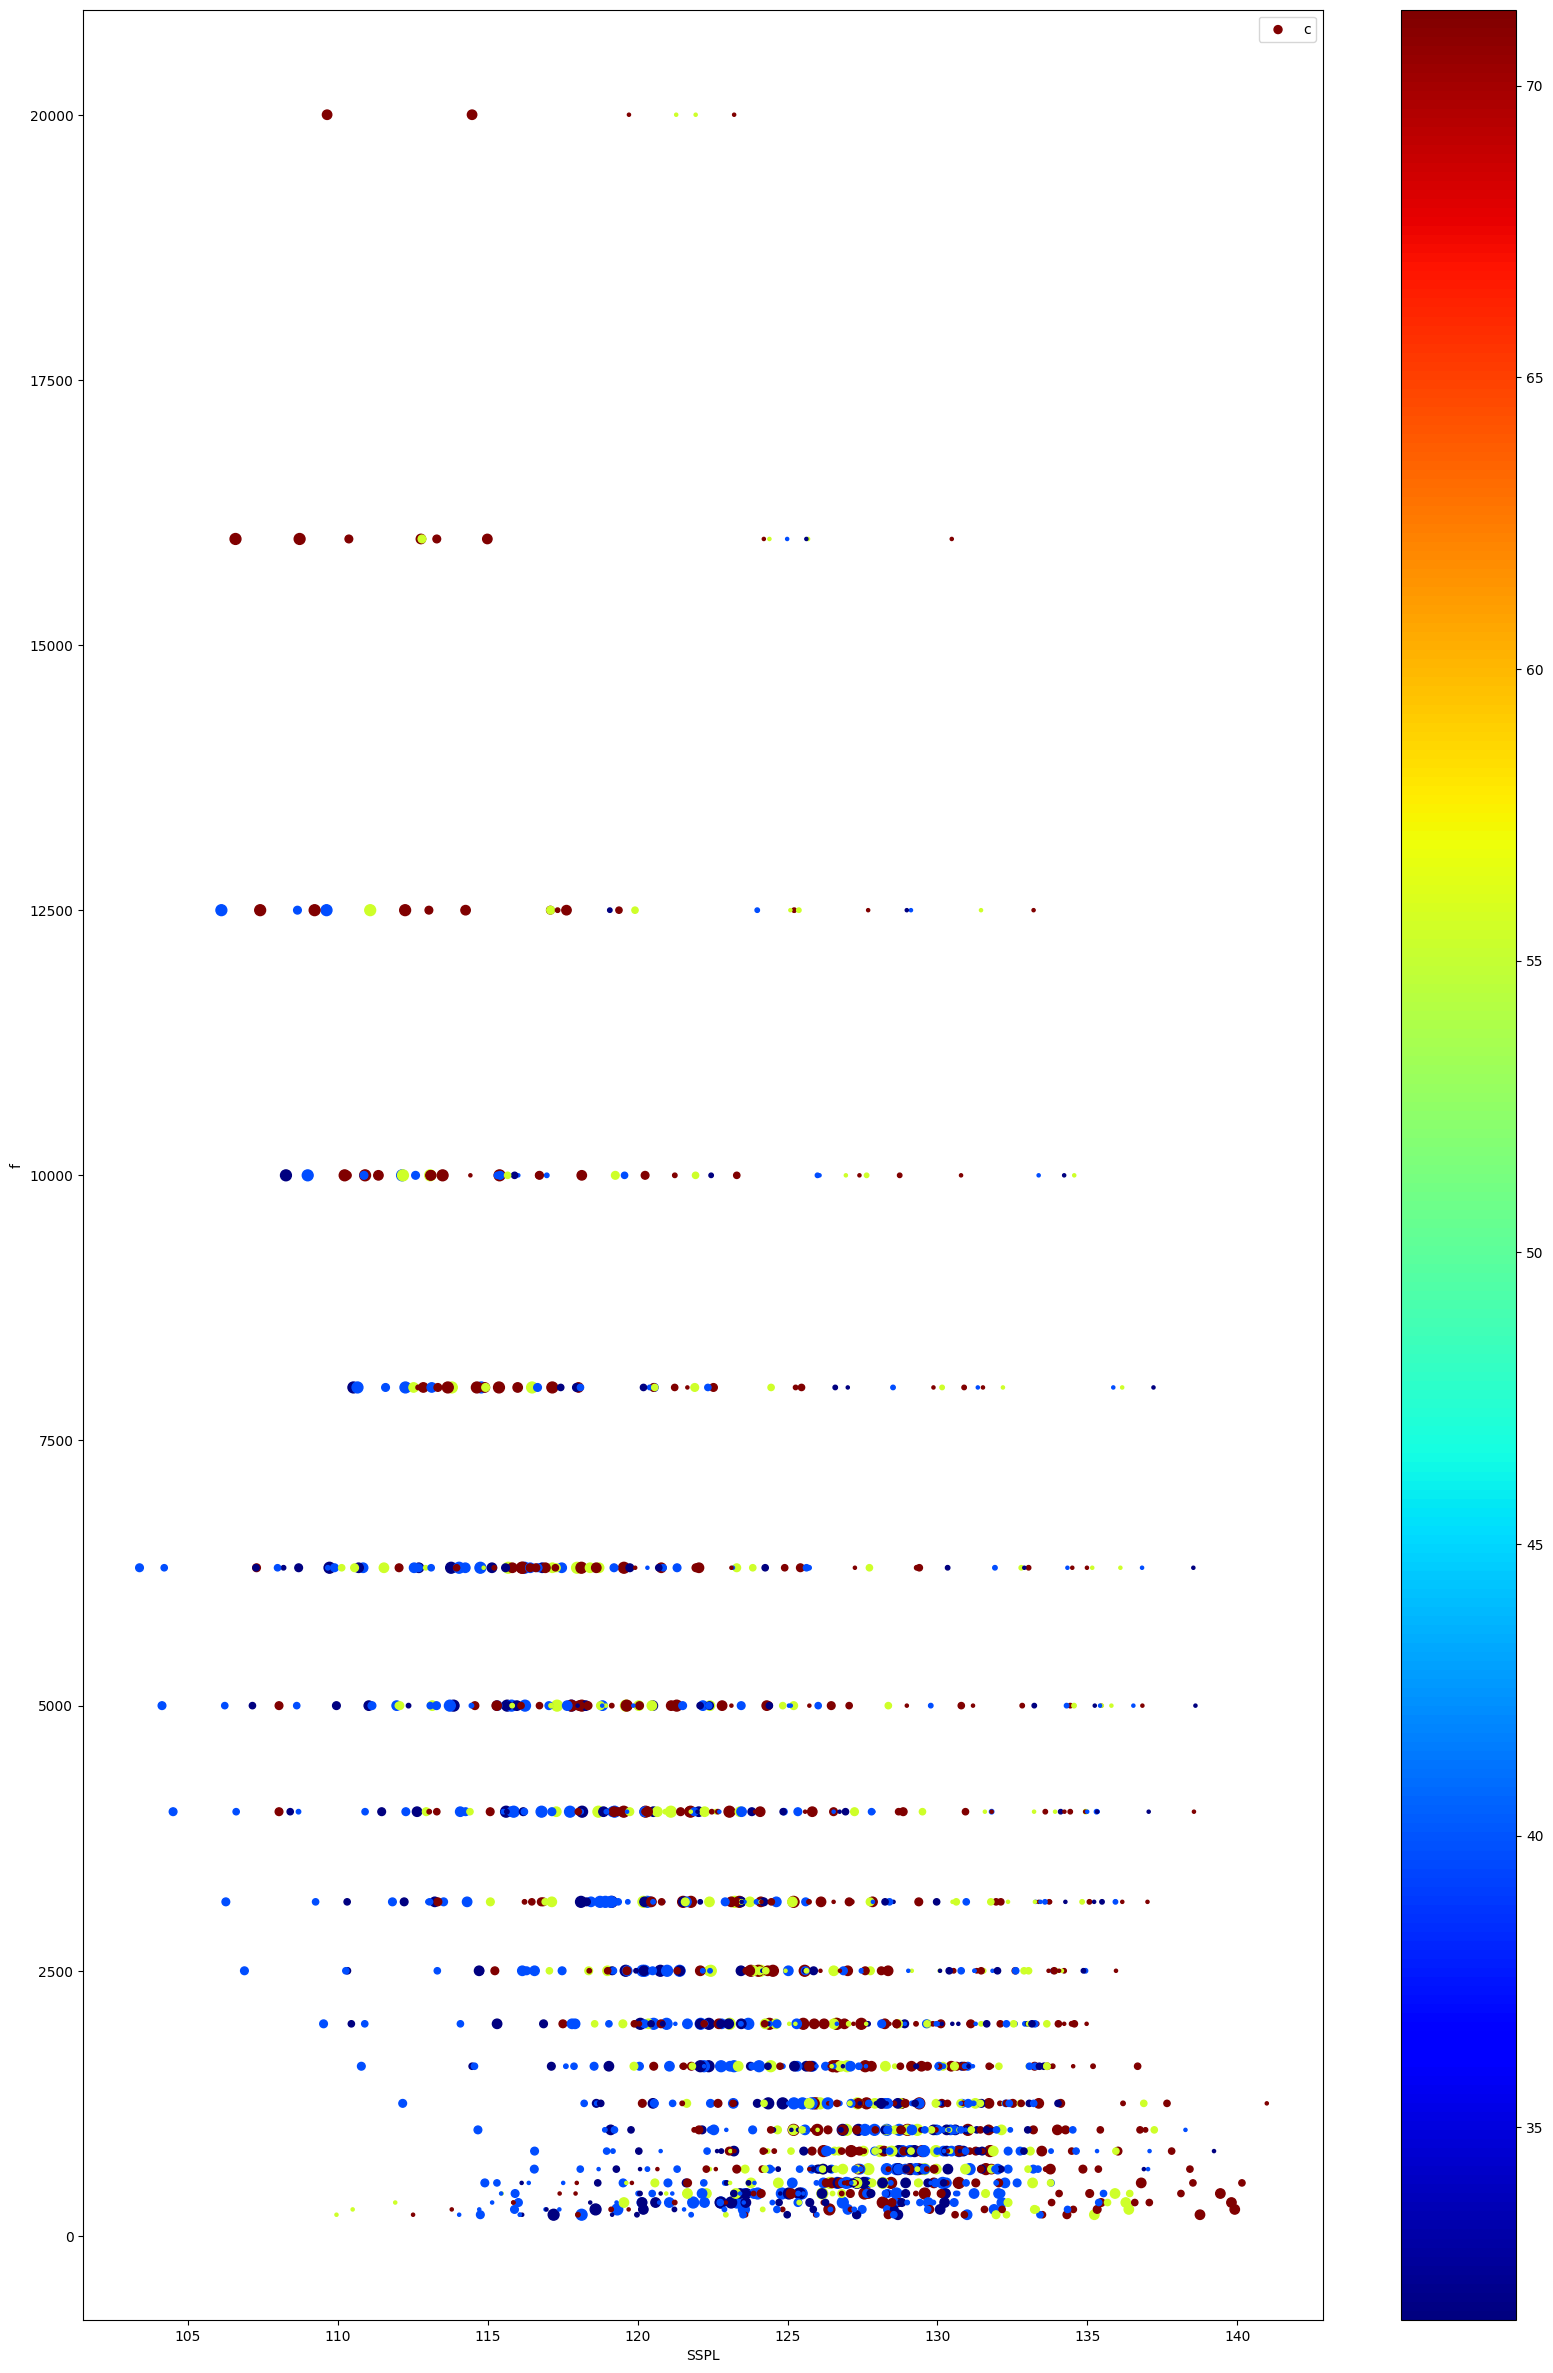

In [40]:
data.plot(kind="scatter", x = "SSPL", y = "f", 
          c=data["U_infinity"], cmap=plt.get_cmap("jet"),
          s=data["c"]*200, label="c",                                   
          figsize=(20,30))


### Data Preprocessing

#### The dataset excluding target column

In [34]:
# features and label
x = data.drop("SSPL", axis="columns")
y = data.SSPL

In [35]:
# Split train set and test set
train_set, test_set, train_label, test_label = train_test_split(x, y, test_size=0.2, random_state=0)
train_set.shape, test_set.shape, train_label.shape, test_label.shape
train_set

,f,alpha,c,U_infinity,delta
1058,800,9.5,0.0254,71.3,0.004207
408,315,7.3,0.2286,55.5,0.011171
703,2000,12.6,0.1524,71.3,0.048316
1279,8000,0.0,0.1016,39.6,0.001463
140,6300,3.0,0.3048,39.6,0.004957
...,...,...,...,...,...
763,12500,0.0,0.0508,39.6,0.000792
835,1250,8.4,0.0508,31.7,0.005808
1216,1250,22.2,0.0254,71.3,0.021418
559,1250,5.4,0.1524,55.5,0.004333


In [36]:
## scale the dataset excluding target column
# train set scaling
scaler = StandardScaler()
train_set_scaled = scaler.fit_transform(train_set)
train_set_scaled = pd.DataFrame(train_set_scaled, columns= x.columns)
# test set scaling
test_set_scaled = scaler.fit_transform(test_set)
test_set_scaled = pd.DataFrame(test_set_scaled, columns= x.columns)

In [37]:
# check a model: XGBoost
xgb = XGBRegressor()
xgb.fit(train_set_scaled, train_label)
score = xgb.score(test_set_scaled, test_label)
score

0.7451014266976193

### Evaluate Different Algorithms

In [38]:
## Cross_Validation

def model_selector(estimator):
    squred_error = cross_val_score(estimator, train_set_scaled, train_label, scoring="neg_mean_squared_error", cv=10)
    sqrt_error = np.sqrt(-squred_error)
    mean_error = sqrt_error.mean()
    std_error = sqrt_error.std()
    return mean_error, std_error

In [39]:
estimators = [LinearRegression, DecisionTreeRegressor, RandomForestRegressor, XGBRegressor]
means = []
stds = []
for i in range(len(estimators)):
    estimator = estimators[i]
    mean, std = model_selector(estimator())
    means.append(mean)
    stds.append(std)

In [40]:
set = [means,stds]
set_array = np.array(set)
set_frame = pd.DataFrame(set_array, columns=["LinearRegression", "DecisionTreeRegressor", "RandomForestRegressor", "XGBRegressor"], index= ["mean", "std"])
set_frame

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,XGBRegressor
mean,4.881498,2.636520,1.775980,1.551416
std,0.384311,0.299151,0.183765,0.188308


In [41]:
## Hyperparameter Optimization
## Based on the above table, XGBRegressor is better. So we should optimize hyperparameters
param_grid = [{"n_estimators":[100, 500, 1000, 2000], "max_depth":[3,6,9], "learning_rate":[0.5,0.1,0.05,0.01]}]
estimator = XGBRegressor()
grid_search = GridSearchCV(estimator= estimator, param_grid= param_grid, scoring= "neg_mean_squared_error", cv= 5)
grid_search.fit(train_set_scaled, train_label)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid=[{'learning_rate': [0.5, 0.1, 0.05, 0.01],
                          'max_depth': [3, 6, 9],
                          'n_estimators': [100, 500, 1000, 2000]}],
             scoring='neg_mean_squared_error')

In [42]:
# Select the best algorithm
print("best_parametere =", grid_search.best_params_)

best_parametere = {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 2000}


In [43]:
## Test the model on test set
best_estimator = grid_search.best_estimator_
prediction = best_estimator.predict(test_set_scaled)
mse = mean_squared_error(test_label, prediction)
sqrt = np.sqrt(mse)
print(sqrt)

score = best_estimator.score(test_set_scaled, test_label)
print(score)

3.498158148225724
0.7398518704695464


In [47]:
sample = np.array([10000, 0, 0.025, 71.3, 0.0004]).reshape(1,-1)
sample_prediction = best_estimator.predict(sample)
sample_prediction

array([108.44573], dtype=float32)

###### The real value for this sample is 130.7. 
###### the prediction is far away from reality.
###### The reason can be beacuse of the spilliting the target from features before scaling.
###### It may be better to scale the entire dataset and then seperate the target from features.
###### To this end, Follow the below structure 

### Scale the entire dataset including target column

In [50]:
# scale entire dataset
scaler = StandardScaler()
scaler.fit(data)
scaled = scaler.transform(data)
scaled = pd.DataFrame(scaled, columns= data.columns)

In [53]:
## split to train and test sets
x = scaled.drop("SSPL", axis="columns")
y = scaled.SSPL
train_set, test_set, train_label, test_label = train_test_split(x, y, test_size=0.2, random_state=0)

In [84]:
# Hyperparameter Optimization
param_grid = [{"n_estimators":[1000, 2000, 3000], "max_depth":[6,9,12], "learning_rate":[0.5,0.05,0.01]}]
estimator = XGBRegressor()
grid_search = GridSearchCV(estimator= estimator, param_grid= param_grid, scoring= "neg_mean_squared_error", cv= 5)
grid_search.fit(train_set, train_label)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid=[{'learning_rate': [0.5, 0.05, 0.01],
                          'max_depth': [6, 9, 12],
                          'n_estimators': [1000, 2000, 3000]}],
             scoring='neg_mean_squared_error')

In [85]:
# Select the best hyperparameters
print("best_parametere =", grid_search.best_params_)

best_parametere = {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 3000}


In [89]:
best_estimator = grid_search.best_estimator_

score = best_estimator.score(test_set, test_label)

prediction = best_estimator.predict(test_set)
error = mean_squared_error(test_label, prediction)
error = np.sqrt(error)
print("error = ", error, ", score = ",score)

error =  0.2131222673582252 , score =  0.954076022709412


In [90]:
sample = test_set.values[0].reshape(1,-1)
sample = pd.DataFrame(sample, columns=train_set.columns)

predicted = best_estimator.predict(sample)
predicted = pd.DataFrame(predicted, columns=["predicted"])

predicted_row = pd.concat([sample, predicted], axis=1)

scaler.inverse_transform(predicted_row.values.reshape(1,-1))

array([[ 1.00000000e+04, -8.88178420e-16,  2.54000000e-02,
         7.13000000e+01,  4.00682000e-04,  1.31965746e+02]])

In [91]:
test_set.iloc[0]

f             2.257200
alpha        -1.146403
c            -1.188629
U_infinity    1.312935
delta        -0.816926
Name: 968, dtype: float64

In [92]:
data.iloc[968]

f             10000.000000
alpha             0.000000
c                 0.025400
U_infinity       71.300000
delta             0.000401
SSPL            130.787000
Name: 968, dtype: float64

Check the results: original SSPL = 130.787, the predicted SSPL = 131.96
It is better than the previous practice

#### Use the scaler and best estimator to predict the SSPL of a sample

In [93]:
def final_predictor(f, alpha, c, U_infinity, delta):
    sample = np.array([f, alpha, c, U_infinity, delta, 0]).reshape(1,-1)
    sample = pd.DataFrame(sample, columns=["f","alpha","c","U_infinity","delta","SSPL"])

    sample_scaled = scaler.transform(sample)
    sample_scaled = pd.DataFrame(sample_scaled, columns=["f","alpha","c","U_infinity","delta","SSPL"])
    sample_scaled = sample_scaled.drop(["SSPL"],axis="columns")

    predicted = best_estimator.predict(sample_scaled)
    predicted = pd.DataFrame(predicted, columns=["predicted"])

    predicted_row = pd.concat([sample_scaled, predicted], axis=1)

    inverted_prediction = scaler.inverse_transform(predicted_row.values.reshape(1,-1))
    return inverted_prediction

In [94]:
f, alpha, c, U_infinity, delta = 10000, 0, 0.025, 71.3, 0.0004

predicted_sspl = final_predictor(f, alpha, c, U_infinity, delta)
predicted_sspl

array([[ 1.00000000e+04, -8.88178420e-16,  2.50000000e-02,
         7.13000000e+01,  4.00000000e-04,  1.31965746e+02]])